# Phase 1: ELO Prediction Model

## Learning Problem

**Objective**: Estimate a chess player's true skill level (ELO rating) from observable game features using supervised regression.

**Problem Type**: Supervised Learning - Regression

**Input**: Game-level features extracted from chess matches including move statistics (captures, checks, castling), game metadata (time control, opening, result), and opponent strength. After feature engineering and one-hot encoding of categorical variables, we obtain 87 features per game.

**Output**: A continuous ELO rating value (400-3000 range) representing the player's chess skill level.

**Challenge**: ELO ratings are inherently noisy - a player's stated rating may not reflect their true skill due to rating inflation, sandbagging, or inconsistent play. Additionally, a single game provides limited information, requiring the model to generalize from sparse observations. The model must learn the complex relationship between playing patterns and skill level across different rating ranges and playing styles.

**Approach**: We employ a neural network with residual connections (128→64→64 neurons) trained on 80,000+ games from Lichess and Chess.com. The architecture includes batch normalization and dropout for regularization, with the most important feature being opponent rating (which provides strong context for performance evaluation). The model is trained using MSE loss with early stopping to prevent overfitting.

In [1]:
! pip install pandas numpy matplotlib seaborn scikit-learn torch scipy tqdm python-chess

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from collections import defaultdict

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
%matplotlib inline

np.random.seed(42)
torch.manual_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## 1. Load Datasets

In [3]:
# Load both datasets
print("Loading datasets...")
lichess_df = pd.read_csv('data/Chess Game Dataset (Lichess).csv')
chesscom_df = pd.read_csv('data/60,000+ Chess Game Dataset (Chess.com).csv')

print(f"Lichess: {lichess_df.shape}")
print(f"Chess.com: {chesscom_df.shape}")

Loading datasets...
Lichess: (20058, 16)
Chess.com: (66879, 14)


## 2. Data Standardization

Pick key variables from both datasets, standardize them, and combine them into one

In [4]:
def parse_winner_chesscom(row):
    white_res = str(row.get('white_result', '')).lower()
    black_res = str(row.get('black_result', '')).lower()
    if 'win' in white_res or 'checkmated' in black_res:
        return 'white'
    elif 'win' in black_res or 'checkmated' in white_res:
        return 'black'
    return 'draw'

def parse_moves_from_pgn(pgn_str):
    if pd.isna(pgn_str):
        return None, 0
    try:
        pgn = str(pgn_str)
        moves_start = pgn.find('1.')
        if moves_start == -1:
            moves_start = pgn.find('1 ')
        if moves_start == -1:
            return None, 0
        moves_text = pgn[moves_start:]
        for ending in ['1-0', '0-1', '1/2-1/2', '*']:
            moves_text = moves_text.replace(ending, '')
        moves_text = moves_text.strip()
        
        import re
        move_numbers = re.findall(r'\d+\.', moves_text)
        turns = len(move_numbers) if move_numbers else 0
        return moves_text, turns
    except:
        return None, 0

# Standardize Lichess
lichess_std = pd.DataFrame({
    'white_rating': lichess_df['white_rating'],
    'black_rating': lichess_df['black_rating'],
    'winner': lichess_df['winner'],
    'turns': lichess_df['turns'],
    'moves': lichess_df['moves'],
    'opening_eco': lichess_df['opening_eco'],
    'opening_ply': lichess_df['opening_ply'],
    'victory_status': lichess_df['victory_status'],
    'rated': lichess_df['rated'],
    'time_control': lichess_df['increment_code'].apply(lambda x: 'blitz' if '+' in str(x) and int(str(x).split('+')[0]) < 180 else 'rapid'),
    'dataset_source': 'lichess'
})

# Standardize Chess.com
moves_and_turns = chesscom_df['pgn'].apply(parse_moves_from_pgn)
moves_list = [x[0] for x in moves_and_turns]
turns_list = [x[1] for x in moves_and_turns]

chesscom_std = pd.DataFrame({
    'white_rating': chesscom_df['white_rating'],
    'black_rating': chesscom_df['black_rating'],
    'winner': chesscom_df.apply(parse_winner_chesscom, axis=1),
    'turns': turns_list,
    'moves': moves_list,
    'opening_eco': None,
    'opening_ply': None,
    'victory_status': None,
    'rated': chesscom_df['rated'],
    'time_control': chesscom_df['time_class'],
    'dataset_source': 'chesscom'
})

# Combine
df = pd.concat([lichess_std, chesscom_std], ignore_index=True)
print(f"\nCombined dataset: {df.shape}")


Combined dataset: (86937, 11)


## 3. Move Feature Extraction (Selected Features Only)

Given the moves, extract relevant information to be used for training and detection

In [5]:
def extract_simple_move_features(moves_str):
    """Extract only the most important move features"""
    if pd.isna(moves_str):
        return {
            'num_captures': 0,
            'num_checks': 0,
            'capture_rate': 0,
            'avg_move_length': 0,
        }
    
    moves = str(moves_str).replace('.', ' ').split()
    moves = [m for m in moves if not m.replace('.', '').isdigit() 
             and m not in ['1-0', '0-1', '1/2-1/2', '*']]
    
    num_moves = len(moves)
    if num_moves == 0:
        return {
            'num_captures': 0,
            'num_checks': 0,
            'capture_rate': 0,
            'avg_move_length': 0,
        }
    
    num_captures = sum(1 for m in moves if 'x' in m)
    num_checks = sum(1 for m in moves if '+' in m and '#' not in m)
    move_lengths = [len(m.replace('+', '').replace('#', '').replace('x', '')) for m in moves]
    
    return {
        'num_captures': num_captures,
        'num_checks': num_checks,
        'capture_rate': num_captures / num_moves,
        'avg_move_length': np.mean(move_lengths) if move_lengths else 0,
    }

# Clean data
df_clean = df.dropna(subset=['white_rating', 'black_rating']).copy()
df_clean = df_clean[
    (df_clean['white_rating'] >= 600) & (df_clean['white_rating'] <= 2800) &
    (df_clean['black_rating'] >= 600) & (df_clean['black_rating'] <= 2800)
]

if 'rated' in df_clean.columns:
    df_clean = df_clean[df_clean['rated'] == True]

print(f"Clean dataset: {df_clean.shape}")

# Extract move features
print("\nExtracting simplified move features...")
move_features = df_clean['moves'].apply(extract_simple_move_features)
move_features_df = pd.DataFrame(move_features.tolist())
df_clean = pd.concat([df_clean, move_features_df], axis=1)

print("Move features extracted!")
df_clean.head()

Clean dataset: (76238, 11)

Extracting simplified move features...
Move features extracted!


white_rating  black_rating winner  turns  \
1        1322.0        1261.0  black   16.0   
2        1496.0        1500.0  white   61.0   
3        1439.0        1454.0  white   61.0   
4        1523.0        1469.0  white   95.0   
6        1520.0        1423.0  white   33.0   

                                               moves opening_eco opening_ply  \
1  d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...         B00           4   
2  e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...         C20           3   
3  d4 d5 Nf3 Bf5 Nc3 Nf6 Bf4 Ng4 e3 Nc6 Be2 Qd7 O...         D02           3   
4  e4 e5 Nf3 d6 d4 Nc6 d5 Nb4 a3 Na6 Nc3 Be7 b4 N...         C41           5   
6  d4 d5 e4 dxe4 Nc3 Nf6 f3 exf3 Nxf3 Nc6 Bb5 a6 ...         D00          10   

  victory_status rated time_control dataset_source  num_captures  num_checks  \
1         resign  True        blitz        lichess          17.0         8.0   
2           mate  True        blitz        lichess          14.0        12.0   
3           mate  True        blitz        lichess          24.0         8.0   
4           mate  True        blitz        lichess          10.0         4.0   
6         resign  True        blitz        lichess          27.0        13.0   

   capture_rate  avg_move_length  
1      0.278689         2.754098  
2      0.229508         2.934426  
3      0.252632         2.821053  
4      0.303030         2.818182  
6      0.226891         2.848739

## 4. Simplified Categorical Encoding

Instead of one-hot encoding all opening names (creates 100+ features), we'll:
1. Group rare openings into "other"
2. Use target encoding for high-cardinality features

In [6]:
def create_dual_perspective_dataset(df):
    """Create dual-perspective dataset"""
    white_df = df.copy()
    white_df['target_rating'] = white_df['white_rating']
    white_df['opponent_rating'] = white_df['black_rating']
    white_df['color'] = 'white'
    white_df['won'] = (white_df['winner'] == 'white').astype(int)
    white_df['lost'] = (white_df['winner'] == 'black').astype(int)
    white_df['draw'] = (white_df['winner'] == 'draw').astype(int)
    
    black_df = df.copy()
    black_df['target_rating'] = black_df['black_rating']
    black_df['opponent_rating'] = black_df['white_rating']
    black_df['color'] = 'black'
    black_df['won'] = (black_df['winner'] == 'black').astype(int)
    black_df['lost'] = (black_df['winner'] == 'white').astype(int)
    black_df['draw'] = (black_df['winner'] == 'draw').astype(int)
    
    combined = pd.concat([white_df, black_df], ignore_index=True)
    return combined

df_dual = create_dual_perspective_dataset(df_clean)
print(f"Dual-perspective dataset: {df_dual.shape}")

# Group rare ECO codes
if 'opening_eco' in df_dual.columns:
    eco_counts = df_dual['opening_eco'].value_counts()
    rare_ecos = eco_counts[eco_counts < 100].index
    df_dual['opening_eco_grouped'] = df_dual['opening_eco'].apply(
        lambda x: 'other' if x in rare_ecos else x
    )
    print(f"ECO codes: {df_dual['opening_eco'].nunique()} → {df_dual['opening_eco_grouped'].nunique()}")

Dual-perspective dataset: (172648, 21)
ECO codes: 351 → 69


## 5. Optimized Feature Selection

In [7]:
# Core features - most predictive
base_features = [
    'opponent_rating',  # Most important
    'won',
    'lost',
    'draw',
    'turns',
    'num_captures',
    'num_checks',
    'capture_rate',
    'avg_move_length',
]

# Add opening_ply if available
if 'opening_ply' in df_dual.columns:
    base_features.append('opening_ply')

# Simplified categorical features (only most important)
categorical_features = []
if 'color' in df_dual.columns:
    categorical_features.append('color')
if 'victory_status' in df_dual.columns:
    categorical_features.append('victory_status')
if 'opening_eco_grouped' in df_dual.columns:
    categorical_features.append('opening_eco_grouped')
if 'time_control' in df_dual.columns:
    categorical_features.append('time_control')

print("=" * 60)
print("OPTIMIZED FEATURE SET")
print("=" * 60)
print(f"Numeric features ({len(base_features)}): {base_features}")
print(f"Categorical features ({len(categorical_features)}): {categorical_features}")
print("=" * 60)

OPTIMIZED FEATURE SET
Numeric features (10): ['opponent_rating', 'won', 'lost', 'draw', 'turns', 'num_captures', 'num_checks', 'capture_rate', 'avg_move_length', 'opening_ply']
Categorical features (4): ['color', 'victory_status', 'opening_eco_grouped', 'time_control']


## 6. Data Preparation with Improved Encoding

In [8]:
# Remove rows with missing target
df_dual_clean = df_dual.dropna(subset=['target_rating']).copy()
print(f"Removed {len(df_dual) - len(df_dual_clean)} rows with missing targets")

# Prepare feature matrix
X = df_dual_clean[base_features].copy()
y = df_dual_clean['target_rating'].values

# Fill NaNs
X = X.fillna(X.mean())

# Handle categorical features with limited one-hot encoding
if categorical_features:
    categorical_df = df_dual_clean[categorical_features].copy()
    for col in categorical_features:
        categorical_df[col] = categorical_df[col].fillna('unknown')
    
    categorical_encoded = pd.get_dummies(categorical_df, columns=categorical_features, drop_first=True)
    X = pd.concat([X, categorical_encoded], axis=1)

# Remove any remaining NaNs
valid_mask = ~(X.isnull().any(axis=1) | np.isnan(y))
X = X[valid_mask]
y = y[valid_mask]

print(f"Final dataset: X={X.shape}, y={y.shape}")
print(f"Total features: {X.shape[1]}")

Removed 20172 rows with missing targets
Final dataset: X=(152476, 87), y=(152476,)
Total features: 87


## 7. Train/Val/Test Split

In [9]:
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.15, random_state=42)

print(f"Train: {X_train.shape[0]}, Val: {X_val.shape[0]}, Test: {X_test.shape[0]}")

# Standardize
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

Train: 110163, Val: 19441, Test: 22872


## 8. Model Architecture

In [10]:
class ChessRatingDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).view(-1, 1)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = ChessRatingDataset(X_train_scaled, y_train)
val_dataset = ChessRatingDataset(X_val_scaled, y_val)
test_dataset = ChessRatingDataset(X_test_scaled, y_test)

batch_size = 512
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"DataLoaders created with batch size {batch_size}")

DataLoaders created with batch size 512


In [11]:
class OptimizedELOPredictor(nn.Module):
    """Optimized architecture with residual connections"""
    def __init__(self, input_dim, hidden_dims=[128, 64], dropout=0.2):
        super().__init__()
        
        self.input_layer = nn.Linear(input_dim, hidden_dims[0])
        self.bn1 = nn.BatchNorm1d(hidden_dims[0])
        
        self.hidden1 = nn.Linear(hidden_dims[0], hidden_dims[1])
        self.bn2 = nn.BatchNorm1d(hidden_dims[1])
        
        self.hidden2 = nn.Linear(hidden_dims[1], hidden_dims[1])
        self.bn3 = nn.BatchNorm1d(hidden_dims[1])
        
        self.output = nn.Linear(hidden_dims[1], 1)
        
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        # Input layer
        x = self.relu(self.bn1(self.input_layer(x)))
        x = self.dropout(x)
        
        # First hidden layer
        x = self.relu(self.bn2(self.hidden1(x)))
        identity = x
        x = self.dropout(x)
        
        # Second hidden with residual
        x = self.bn3(self.hidden2(x))
        x = x + identity  # Residual connection
        x = self.relu(x)
        x = self.dropout(x)
        
        # Output
        return self.output(x)

input_dim = X_train_scaled.shape[1]
model = OptimizedELOPredictor(input_dim, hidden_dims=[128, 64], dropout=0.2).to(device)

print(f"Model parameters: {sum(p.numel() for p in model.parameters())}")
print(model)

Model parameters: 24257
OptimizedELOPredictor(
  (input_layer): Linear(in_features=87, out_features=128, bias=True)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (hidden1): Linear(in_features=128, out_features=64, bias=True)
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (hidden2): Linear(in_features=64, out_features=64, bias=True)
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (output): Linear(in_features=64, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (relu): ReLU()
)


## 9. Training

In [12]:
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    for X_batch, y_batch in loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        predictions = model(X_batch)
        loss = criterion(predictions, y_batch)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # Gradient clipping
        optimizer.step()
        total_loss += loss.item() * X_batch.size(0)
    return total_loss / len(loader.dataset)

def validate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds, all_targets = [], []
    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            predictions = model(X_batch)
            loss = criterion(predictions, y_batch)
            total_loss += loss.item() * X_batch.size(0)
            all_preds.extend(predictions.cpu().numpy())
            all_targets.extend(y_batch.cpu().numpy())
    
    all_preds = np.array(all_preds).flatten()
    all_targets = np.array(all_targets).flatten()
    mae = mean_absolute_error(all_targets, all_preds)
    rmse = np.sqrt(mean_squared_error(all_targets, all_preds))
    return total_loss / len(loader.dataset), mae, rmse

# Training setup with better hyperparameters
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5
)

num_epochs = 30
best_val_mae = float('inf')
history = {'train_loss': [], 'val_loss': [], 'val_mae': [], 'val_rmse': []}
patience_counter = 0
patience = 10

print("Starting training with early stopping...\n")

for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_mae, val_rmse = validate(model, val_loader, criterion, device)
    
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['val_mae'].append(val_mae)
    history['val_rmse'].append(val_rmse)
    
    print(f"Epoch {epoch+1:02d}/{num_epochs} | "
          f"Train Loss: {train_loss:.2f} | "
          f"Val MAE: {val_mae:.2f} | "
          f"Val RMSE: {val_rmse:.2f}")
    
    scheduler.step(val_mae)
    
    if val_mae < best_val_mae:
        best_val_mae = val_mae
        torch.save(model.state_dict(), 'best_elo_model_v3.pt')
        print(f"  ✓ Best model saved! (MAE: {val_mae:.2f})")
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"\nEarly stopping at epoch {epoch+1}")
            break

print(f"\nTraining complete! Best Val MAE: {best_val_mae:.2f}")

Starting training with early stopping...

Epoch 01/30 | Train Loss: 1975482.95 | Val MAE: 1346.29 | Val RMSE: 1390.92
  ✓ Best model saved! (MAE: 1346.29)
Epoch 02/30 | Train Loss: 1897781.36 | Val MAE: 1313.03 | Val RMSE: 1353.36
  ✓ Best model saved! (MAE: 1313.03)
Epoch 03/30 | Train Loss: 1769181.77 | Val MAE: 1261.91 | Val RMSE: 1297.13
  ✓ Best model saved! (MAE: 1261.91)
Epoch 04/30 | Train Loss: 1598921.93 | Val MAE: 1193.42 | Val RMSE: 1223.49
  ✓ Best model saved! (MAE: 1193.42)
Epoch 05/30 | Train Loss: 1399907.17 | Val MAE: 1113.00 | Val RMSE: 1138.12
  ✓ Best model saved! (MAE: 1113.00)
Epoch 06/30 | Train Loss: 1184509.72 | Val MAE: 1008.14 | Val RMSE: 1029.17
  ✓ Best model saved! (MAE: 1008.14)
Epoch 07/30 | Train Loss: 960680.42 | Val MAE: 901.72 | Val RMSE: 920.09
  ✓ Best model saved! (MAE: 901.72)
Epoch 08/30 | Train Loss: 738901.93 | Val MAE: 769.39 | Val RMSE: 786.72
  ✓ Best model saved! (MAE: 769.39)
Epoch 09/30 | Train Loss: 533057.45 | Val MAE: 639.28 | Val RM

## 10. Test Set Evaluation

In [13]:
# Load best model
model.load_state_dict(torch.load('best_elo_model_v3.pt'))
test_loss, test_mae, test_rmse = validate(model, test_loader, criterion, device)

# Get predictions
model.eval()
test_predictions = []
test_actuals = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        preds = model(X_batch)
        test_predictions.extend(preds.cpu().numpy())
        test_actuals.extend(y_batch.numpy())

test_predictions = np.array(test_predictions).flatten()
test_actuals = np.array(test_actuals).flatten()
r2 = r2_score(test_actuals, test_predictions)

print("=" * 60)
print("TEST SET EVALUATION - PHASE 1 V3 (IMPROVED)")
print("=" * 60)
print(f"Test MAE:   {test_mae:.2f} ELO points")
print(f"Test RMSE:  {test_rmse:.2f} ELO points")
print(f"R² Score:   {r2:.4f}")
print("=" * 60)

# Save results
np.savez('phase1_elo_results.npz',
         predictions=test_predictions,
         actuals=test_actuals,
         test_mae=test_mae,
         test_rmse=test_rmse,
         r2=r2)

TEST SET EVALUATION - PHASE 1 V3 (IMPROVED)
Test MAE:   81.29 ELO points
Test RMSE:  133.06 ELO points
R² Score:   0.8635


In [14]:
# Get predictions on test set
model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        predictions = model(X_batch)
        all_preds.extend(predictions.cpu().numpy())
        all_targets.extend(y_batch.numpy())

predictions = np.array(all_preds).flatten()
targets = np.array(all_targets).flatten()
residuals = targets - predictions

print(f"Predictions shape: {predictions.shape}")
print(f"Residuals shape: {residuals.shape}")
print(f"Mean residual: {residuals.mean():.2f}")
print(f"Std residual: {residuals.std():.2f}")

Predictions shape: (22872,)
Residuals shape: (22872,)
Mean residual: 1.81
Std residual: 133.05


In [15]:
print("Residual Statistics:")
print(f"Mean:   {np.mean(residuals):.2f}")
print(f"Std:    {np.std(residuals):.2f}")
print(f"Median: {np.median(residuals):.2f}")
print(f"Min:    {np.min(residuals):.2f}")
print(f"Max:    {np.max(residuals):.2f}")

# Identify potential anomalies (large positive residuals = performing better than expected)
threshold = np.mean(residuals) + 2 * np.std(residuals)
anomaly_mask = residuals > threshold
print(f"\nPotential anomalies (residual > {threshold:.2f}): {np.sum(anomaly_mask)} games ({np.sum(anomaly_mask)/len(residuals)*100:.2f}%)")

Residual Statistics:
Mean:   1.81
Std:    133.05
Median: 2.55
Min:    -1713.58
Max:    1150.60

Potential anomalies (residual > 267.91): 645 games (2.82%)


## 11. Visualizations

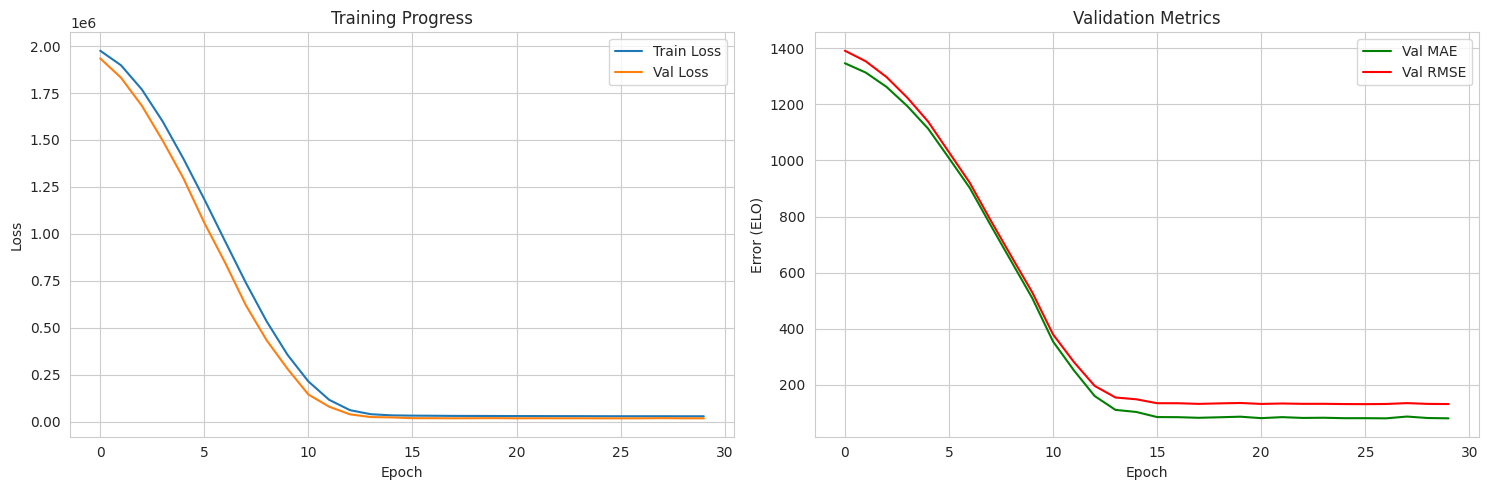

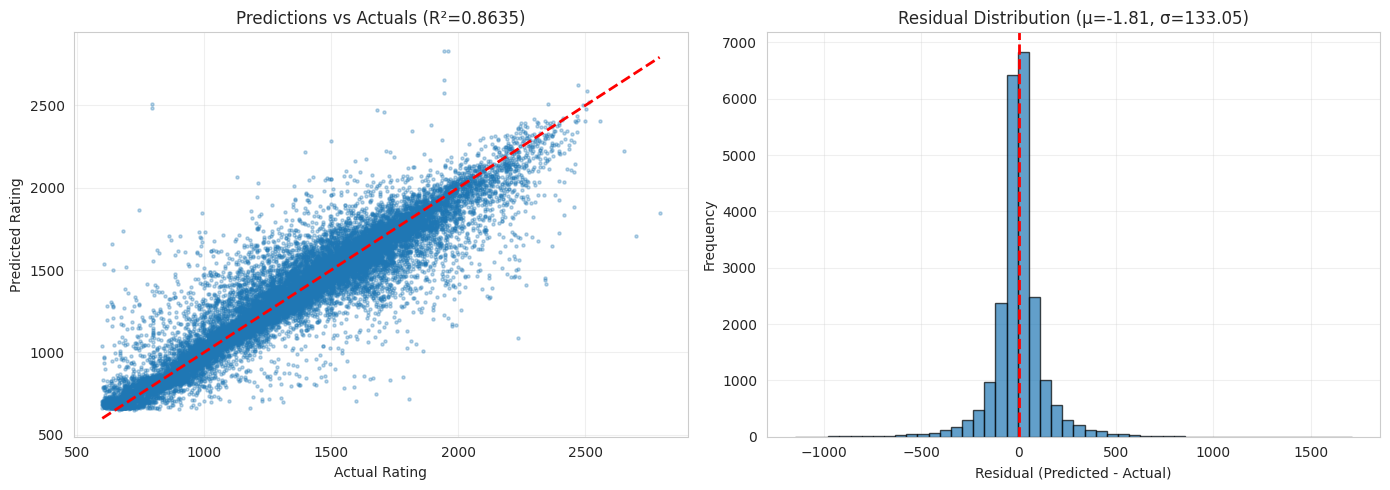

In [16]:
# Training history
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(history['train_loss'], label='Train Loss')
axes[0].plot(history['val_loss'], label='Val Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training Progress')
axes[0].legend()
axes[0].grid(True)

axes[1].plot(history['val_mae'], label='Val MAE', color='green')
axes[1].plot(history['val_rmse'], label='Val RMSE', color='red')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Error (ELO)')
axes[1].set_title('Validation Metrics')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

# Predictions vs Actuals
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].scatter(test_actuals, test_predictions, alpha=0.3, s=5)
axes[0].plot([test_actuals.min(), test_actuals.max()], 
             [test_actuals.min(), test_actuals.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual Rating')
axes[0].set_ylabel('Predicted Rating')
axes[0].set_title(f'Predictions vs Actuals (R²={r2:.4f})')
axes[0].grid(True, alpha=0.3)

residuals = test_predictions - test_actuals
axes[1].hist(residuals, bins=50, edgecolor='black', alpha=0.7)
axes[1].axvline(0, color='red', linestyle='--', linewidth=2)
axes[1].set_xlabel('Residual (Predicted - Actual)')
axes[1].set_ylabel('Frequency')
axes[1].set_title(f'Residual Distribution (μ={np.mean(residuals):.2f}, σ={np.std(residuals):.2f})')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Performance by Rating Range:
    Range  Count        MAE       RMSE
   0-1000   3836  76.436661 136.120409
1000-1200   3728  70.146179 116.750807
1200-1400   4868  67.503258 110.508537
1400-1600   4502  74.074867 114.921751
1600-1800   3349  90.018295 135.548423
1800-2000   1619 117.464737 178.100316
2000-2200    647 141.718643 204.800370
2200-3000    323 182.905716 273.457749


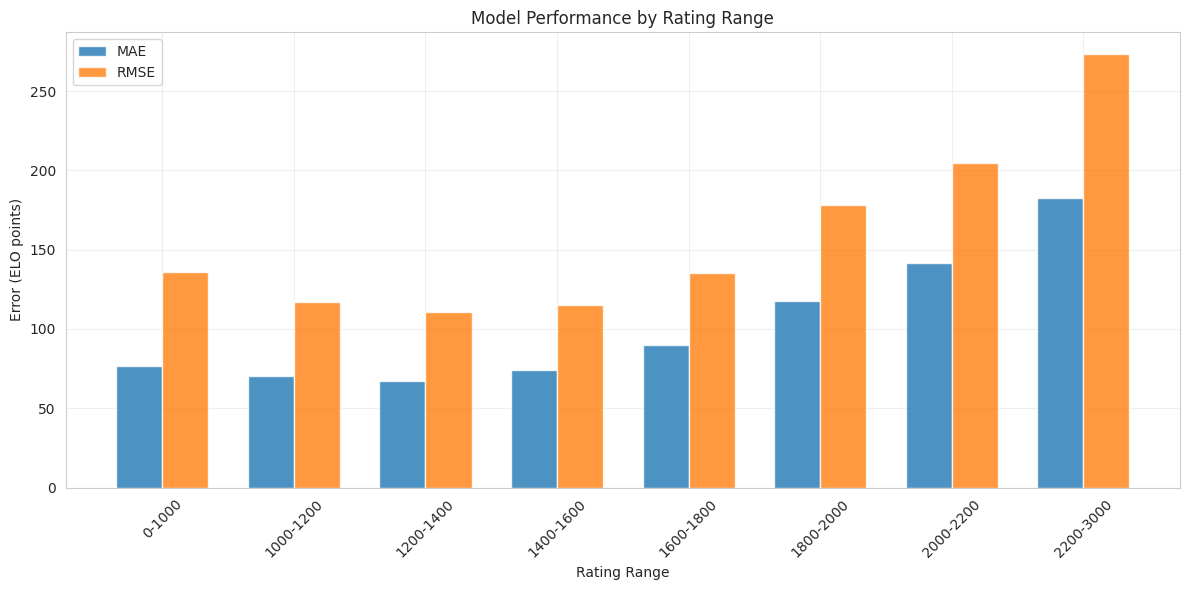

In [17]:
# Analyze performance by rating range
rating_ranges = [(0, 1000), (1000, 1200), (1200, 1400), (1400, 1600), 
                 (1600, 1800), (1800, 2000), (2000, 2200), (2200, 3000)]

range_stats = []
for low, high in rating_ranges:
    mask = (test_actuals >= low) & (test_actuals < high)
    if np.sum(mask) > 0:
        range_mae = mean_absolute_error(test_actuals[mask], test_predictions[mask])
        range_rmse = np.sqrt(mean_squared_error(test_actuals[mask], test_predictions[mask]))
        range_stats.append({
            'Range': f'{low}-{high}',
            'Count': np.sum(mask),
            'MAE': range_mae,
            'RMSE': range_rmse
        })

range_df = pd.DataFrame(range_stats)
print("Performance by Rating Range:")
print(range_df.to_string(index=False))

# Visualize
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(range_df))
width = 0.35

ax.bar(x - width/2, range_df['MAE'], width, label='MAE', alpha=0.8)
ax.bar(x + width/2, range_df['RMSE'], width, label='RMSE', alpha=0.8)

ax.set_xlabel('Rating Range')
ax.set_ylabel('Error (ELO points)')
ax.set_title('Model Performance by Rating Range')
ax.set_xticks(x)
ax.set_xticklabels(range_df['Range'], rotation=45)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()